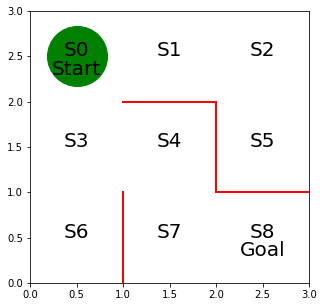

In [1]:
"""迷路課題実装　3*3 S0=>S8 green:actor"""
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

grid=np.array([[0,1,2,3],[0,1,2,3]])
fig=plt.figure(figsize=(5,5))
ax=plt.gca()
plt.xlim(0,3)
plt.ylim(0,3)
#赤い壁の作成
plt.plot((grid[0][1],grid[1][1]),(grid[0][1],grid[1][0]),color='red',linewidth=2)
plt.plot((grid[0][1],grid[1][2]),(grid[0][2],grid[1][2]),color='red',linewidth=2)
plt.plot((grid[0][2],grid[1][2]),(grid[0][2],grid[1][1]),color='red',linewidth=2)
plt.plot((grid[0][3],grid[1][2]),(grid[0][1],grid[1][1]),color='red',linewidth=2)

#テキストボックス
plt.text(0.5,0.5,'S6',size=20,ha='center')
plt.text(0.5,1.5,'S3',size=20,ha='center')
plt.text(0.5,2.5,'S0',size=20,ha='center')
plt.text(0.5,2.3,'Start',size=20,ha='center')
plt.text(1.5,0.5,'S7',size=20,ha='center')
plt.text(2.5,0.5,'S8',size=20,ha='center')
plt.text(2.5,0.3,'Goal',size=20,ha='center')
plt.text(1.5,1.5,'S4',size=20,ha='center')
plt.text(1.5,2.5,'S1',size=20,ha='center')
plt.text(2.5,1.5,'S5',size=20,ha='center')
plt.text(2.5,2.5,'S2',size=20,ha='center')

#初期位置に緑のマーク
line,=ax.plot(0.5,2.5,marker='o',color='g',markersize=60)
plt.show()


#policy 順に上、下、右、左 動ける時を1,動けないときをン氏
theta_0=np.array([[np.nan,1,1,np.nan],
                  [np.nan,np.nan,1,1],
                  [np.nan,1,np.nan,1],
                  [1,1,1,np.nan],
                  [np.nan,1,np.nan,1],
                  [1,np.nan,np.nan,np.nan],
                  [1,np.nan,np.nan,np.nan],
                  [1,np.nan,1,np.nan]])

In [7]:
#確率行列　softmax  na=len(direction) beta:係数
beta=1.0
s,t=theta_0.shape

prob_array=np.zeros([s,t])

for i in range(s):
    prob_array[i,:]=np.exp(theta_0[i,:]*beta)/np.nansum(np.exp(theta_0[i,:]*beta))
    
prob_array=np.nan_to_num(prob_array)

#関数化
def softmax_with_policy_to_prob(theta):
    #coefficient:beta
    beta=1.0
    s,t=theta.shape
    
    #確率行列初期化
    prob_array=np.zeros([s,t])
    
    for i in range(s):
        prob_array[i,:]=np.exp(theta[i,:]*beta)/np.nansum(np.exp(theta[i,:]*beta))
        
    prob_array=np.nan_to_num(prob_array)
    
    return prob_array

prob_array=softmax_with_policy_to_prob(theta_0)
print(prob_array)

[[ 0.          0.5         0.5         0.        ]
 [ 0.          0.          0.5         0.5       ]
 [ 0.          0.5         0.          0.5       ]
 [ 0.33333333  0.33333333  0.33333333  0.        ]
 [ 0.          0.5         0.          0.5       ]
 [ 1.          0.          0.          0.        ]
 [ 1.          0.          0.          0.        ]
 [ 0.5         0.          0.5         0.        ]]


In [13]:
#softmax policyに従ってゴールを目指す
#action next_state を返す

def get_next_state_with_softmax(prob_array,now_state):
    direction=['up','down','right','left']
    next_direction=np.random.choice(direction,p=prob_array[now_state,:])
    
    if next_direction==direction[0]:
        action=0
        next_state=now_state-3
    elif next_direction==direction[1]:
        action=1
        next_state=now_state+3
    elif next_direction==direction[2]:
        action=2
        next_state=now_state+1
    elif next_direction==direction[3]:
        action=3
        next_state=now_state-1
        
    return [action,next_state]


#goal_get
def get_goal(prob_array):
    state=0
    st_ac_history=[[state,np.nan]]
    
    while True:
        [action,next_state]=get_next_state_with_softmax(prob_array,state)
        st_ac_history[-1][1]=action
        
        st_ac_history.append([next_state,np.nan])
        
        if next_state==8:
            break
        else:
            state=next_state
        
    return st_ac_history

s_a_history=get_goal(prob_array)
print(s_a_history)
print('labyrince was solved %d steps'%(len(s_a_history)-1))

        

[[0, 1], [3, 0], [0, 1], [3, 0], [0, 1], [3, 2], [4, 1], [7, 0], [4, 3], [3, 0], [0, 2], [1, 3], [0, 2], [1, 2], [2, 3], [1, 2], [2, 1], [5, 0], [2, 3], [1, 3], [0, 2], [1, 3], [0, 1], [3, 1], [6, 0], [3, 2], [4, 3], [3, 0], [0, 2], [1, 2], [2, 1], [5, 0], [2, 3], [1, 3], [0, 2], [1, 3], [0, 1], [3, 1], [6, 0], [3, 1], [6, 0], [3, 2], [4, 1], [7, 2], [8, nan]]
labyrince was solved 44 steps


In [17]:
#方策勾配法に従い更新　patameterを更新

lr=0.1
m,n=theta_0.shape
T=len(s_a_history)-1
#更新の幅
delta_theta=theta_0.copy()

for i in range(m):
    for j in range(n):
        #thetaがnanでないときには更新可能
        if not (np.isnan(theta_0[i,j])):
            #状態siで行動ajをとったものをリスト化 (si,aj)
            si_aj=[u for u in s_a_history if u==[i,j]]
            #状態siで行動aを折る
            si_a=[u for u in s_a_history if u[0]==i]
            
            N_si_aj=len(si_aj)
            N_si_a=len(si_a)
            P_si_aj=prob_array[i,j]
            #勾配を計算
            delta_theta[i,j]=(N_si_aj+P_si_aj*N_si_a)/T
            
#new gradient
new_theta=theta_0+lr*delta_theta
prob_array_old=softmax_with_policy_to_prob(theta_0)
prob_array_new=softmax_with_policy_to_prob(new_theta)

print('old',prob_array_old)
print('new',prob_array_new)
            



old [[ 0.          0.5         0.5         0.        ]
 [ 0.          0.          0.5         0.5       ]
 [ 0.          0.5         0.          0.5       ]
 [ 0.33333333  0.33333333  0.33333333  0.        ]
 [ 0.          0.5         0.          0.5       ]
 [ 1.          0.          0.          0.        ]
 [ 1.          0.          0.          0.        ]
 [ 0.5         0.          0.5         0.        ]]
new [[ 0.          0.5         0.5         0.        ]
 [ 0.          0.          0.49886364  0.50113636]
 [ 0.          0.49943182  0.          0.50056818]
 [ 0.33383858  0.33308071  0.33308071  0.        ]
 [ 0.          0.5         0.          0.5       ]
 [ 1.          0.          0.          0.        ]
 [ 1.          0.          0.          0.        ]
 [ 0.5         0.          0.5         0.        ]]


In [18]:
#方策勾配法を関数化　update
def update(theta,s_a_history,prob_array,lr=0.1):
    m,n=theta.shape
    T=len(s_a_history)-1
    
    #更新勾配行列の定義
    delta_theta=theta.copy()
    
    for i in range(m):
        for j in range(n):
            if not (np.isnan(theta[i,j])):
                #状態siで行動ajをとったものをリスト化
                si_aj=[u for u in s_a_history if u==[i,j]]
                #状態siで行動aをとったものをリスト化
                si_a=[u for u in s_a_history if u[0]==i]
                
                N_si_aj=len(si_aj)
                N_si_a=len(si_a)
                P_si_aj=prob_array[i,j]
                
                #勾配更新行列の要素を計算
                delta_theta[i,j]=(N_si_aj+N_si_a*P_si_aj)/T
    #更新
    new_theta=theta+lr*delta_theta
    return new_theta

prob_array=softmax_with_policy_to_prob(theta_0)
new_theta=update(theta_0,s_a_history,prob_array)
#方策を確率化
new_prob_array=softmax_with_policy_to_prob(new_theta)

print(new_prob_array)

[[ 0.          0.5         0.5         0.        ]
 [ 0.          0.          0.49886364  0.50113636]
 [ 0.          0.49943182  0.          0.50056818]
 [ 0.33383858  0.33308071  0.33308071  0.        ]
 [ 0.          0.5         0.          0.5       ]
 [ 1.          0.          0.          0.        ]
 [ 1.          0.          0.          0.        ]
 [ 0.5         0.          0.5         0.        ]]


In [19]:
#方策勾配法で迷路を解いていく 強化学習

#policyの変化度合いで学習をやめる閾値を設定
stop_eps=1.0e-8

theta=theta_0
prob_array=softmax_with_policy_to_prob(theta_0)

is_continue=True
count=1

while is_continue:
    s_a_history=get_goal(prob_array)
    new_theta=update(theta,s_a_history,prob_array,lr=0.1)
    new_prob_array=softmax_with_policy_to_prob(new_theta)
    
    error=np.sum(np.abs(new_prob_array-prob_array))
    print(error)#方策の変化を出力
    print('labyrince was solved %d times required'%(len(s_a_history)-1))
    
    if error<stop_eps:
        is_continue=False
    else:
        theta=new_theta
        prob_array=new_prob_array
        print('steps',count)
        count+=1
        


0.0486550645929
labyrince was solved 4 times required
steps 1
0.0105762712009
labyrince was solved 26 times required
steps 2
0.0163431069436
labyrince was solved 22 times required
steps 3
0.00961330251019
labyrince was solved 102 times required
steps 4
0.024757859594
labyrince was solved 10 times required
steps 5
0.0496311026384
labyrince was solved 4 times required
steps 6
0.0103701432092
labyrince was solved 66 times required
steps 7
0.0216267370781
labyrince was solved 14 times required
steps 8
0.0334161656503
labyrince was solved 6 times required
steps 9
0.0344799767724
labyrince was solved 6 times required
steps 10
0.0160856789131
labyrince was solved 34 times required
steps 11
0.0229397205455
labyrince was solved 10 times required
steps 12
0.0140347701137
labyrince was solved 22 times required
steps 13
0.014456179159
labyrince was solved 48 times required
steps 14
0.0088636207174
labyrince was solved 68 times required
steps 15
0.0118675068235
labyrince was solved 38 times require

steps 156
0.0217204784886
labyrince was solved 6 times required
steps 157
0.0225072606007
labyrince was solved 8 times required
steps 158
0.0302464921206
labyrince was solved 4 times required
steps 159
0.0207563506778
labyrince was solved 8 times required
steps 160
0.0287246622651
labyrince was solved 4 times required
steps 161
0.02782807082
labyrince was solved 4 times required
steps 162
0.0269429290541
labyrince was solved 4 times required
steps 163
0.0239022647645
labyrince was solved 6 times required
steps 164
0.0186573387076
labyrince was solved 6 times required
steps 165
0.0246602686637
labyrince was solved 4 times required
steps 166
0.0238248773976
labyrince was solved 4 times required
steps 167
0.0164605985961
labyrince was solved 8 times required
steps 168
0.016526416058
labyrince was solved 6 times required
steps 169
0.0218448060918
labyrince was solved 4 times required
steps 170
0.0154708700732
labyrince was solved 6 times required
steps 171
0.02049310399
labyrince was solve

In [20]:
print(prob_array)

[[  0.00000000e+00   9.99999988e-01   1.22945493e-08   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   4.50371270e-01   5.49628730e-01]
 [  0.00000000e+00   5.20734261e-01   0.00000000e+00   4.79265739e-01]
 [  1.47555528e-08   2.23639815e-08   9.99999963e-01   0.00000000e+00]
 [  0.00000000e+00   9.99999990e-01   0.00000000e+00   9.75218263e-09]
 [  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  3.90572088e-08   0.00000000e+00   9.99999961e-01   0.00000000e+00]]
